Explore the C. elegans data
---
Check out the full dataset containing 46k cells from [Packer et al., Science 2019](https://www.science.org/doi/10.1126/science.aax1971) for which partial lineage information is available. 

# Preliminaries

## Import packages

In [2]:
import utils
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'interpolation_parameters' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'account_for_unbalancedness' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'batch_size' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/marius/miniforge3/envs/py39_arm_moslin/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'seed_interpolation' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


## Dependencies

No dependencies. 

## Set up paths

Define the paths for data and figures. 

In [3]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "packer_c_elegans"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [4]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

## Set global parameters

In [5]:
DPI_SAVE = 400

scv.settings.set_figure_params('scvelo', dpi_save=DPI_SAVE, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

In [6]:
# should figures just be displayed or also saved?
save_figure = True

In [7]:
TIME_KEY = "assigned_batch_time"

## Import the data

In [8]:
adata = sc.read(DATA_DIR / "c_elegans.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'cell', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage'
    var: 'Unnamed: 0', 'id', 'gene_short_name'

Make sure cell and gene names are unique. 

In [9]:
assert(len(np.unique(adata.obs["cell"].values)) == adata.n_obs), "Cell names are not unique"
assert(len(np.unique(adata.var["gene_short_name"])) == adata.n_vars), "Gene names are not unique"

Clean up annotations. 

In [10]:
# change the obs index
adata.obs.index = adata.obs["cell"]
adata = adata[adata.obs.index.sort_values()].copy()

# change the var index
adata.var.index = adata.var["gene_short_name"]

# modify time annotations
adata.obs[TIME_KEY] = adata.obs["embryo.time.bin"].apply(utils.assign_time_to_bin)
adata.obs[TIME_KEY] = adata.obs[TIME_KEY].astype("category")
adata.obs = adata.obs.set_index("cell")

Filter to those timepoint that contain enought cells to map them confidently. 

In [11]:
tps = [170, 210, 270, 330, 390, 450, 510]
adata = adata[adata.obs[TIME_KEY].isin(tps)].copy()
adata

AnnData object with n_obs × n_vars = 45732 × 20222
    obs: 'Unnamed: 0', 'Unnamed: 0.1', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time'
    var: 'Unnamed: 0', 'id', 'gene_short_name'

Assign some meaningful colors

In [12]:
tps = adata.obs[TIME_KEY].cat.categories
adata.uns[f"{TIME_KEY}_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(tps)))
]

## Preprocess the data

Normalize total counts

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

Log transform the data

In [14]:
sc.pp.log1p(adata)

Identify highly-variable genes

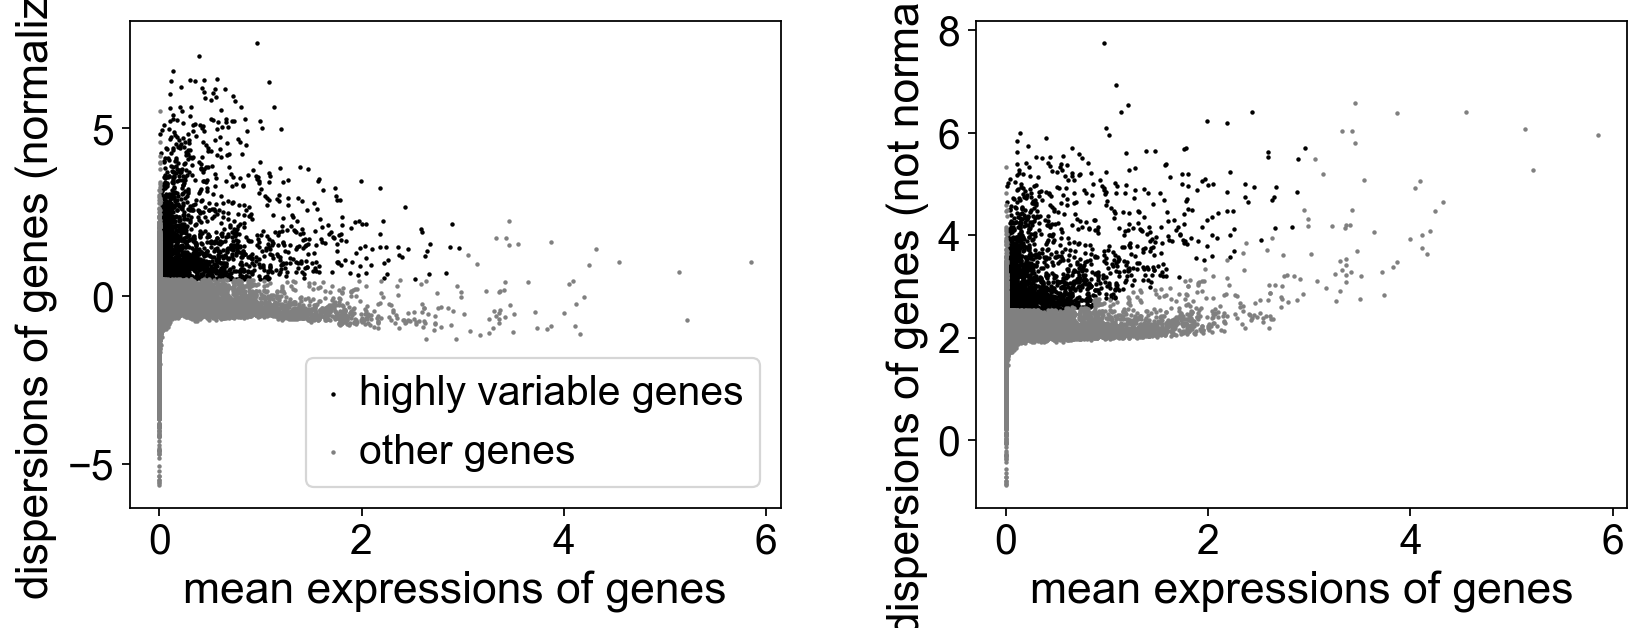

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

How many highly variable genes did this yield?

In [16]:
np.sum(adata.var['highly_variable'])

2544

# Explore this dataset 

## Compute an embedding

Compute a PCA

In [17]:
sc.tl.pca(adata, random_state=0)

Compute a KNN graph. 

In [18]:
sc.pp.neighbors(adata, random_state=0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Compute UMAP. 

In [19]:
sc.tl.umap(adata, random_state=0)

Visualize the UMAP

saving figure to file /Users/marius/Projects/moslin_reproducibility/figures/packer_c_elegans/full_umap_plot_type.pdf


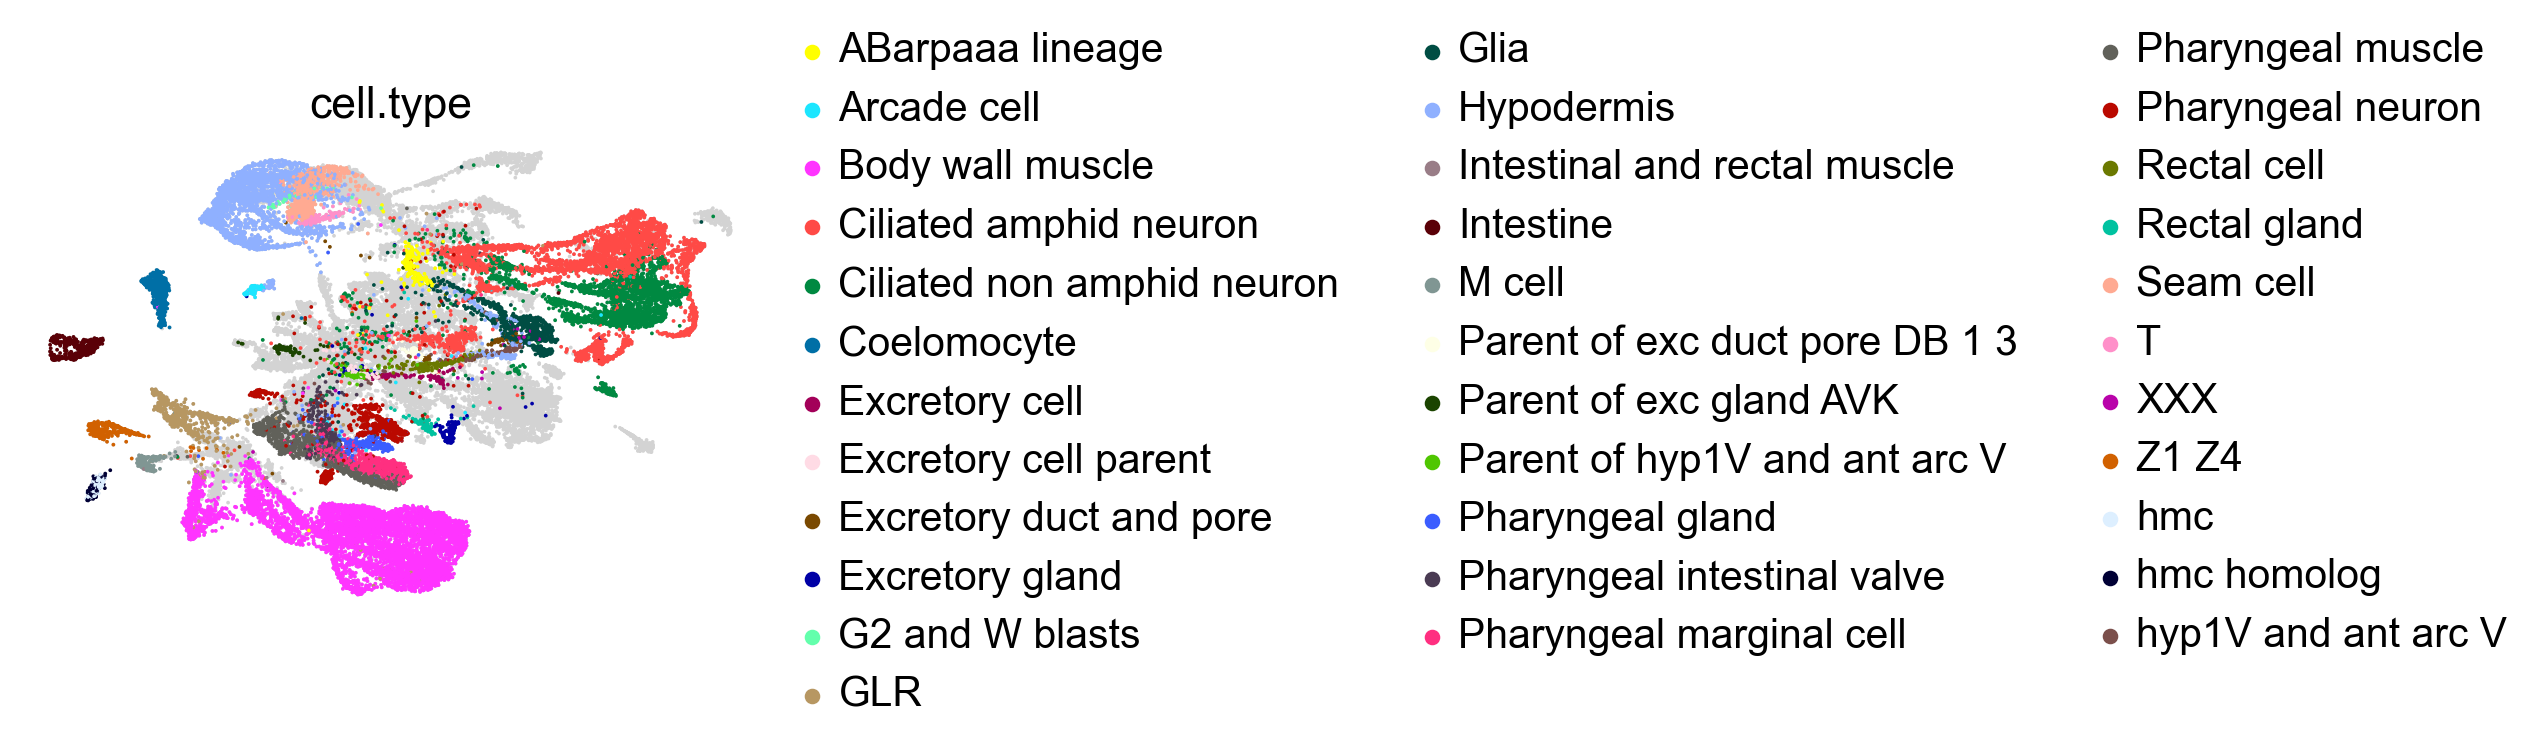

In [20]:
fig_kwargs = {}
if save_figure: fig_kwargs['save'] =  "full_umap_plot_type.pdf"

scv.pl.scatter(adata, basis='umap', color="cell.type", legend_loc='right', **fig_kwargs)

saving figure to file /Users/marius/Projects/moslin_reproducibility/figures/packer_c_elegans/full_umap_time.pdf


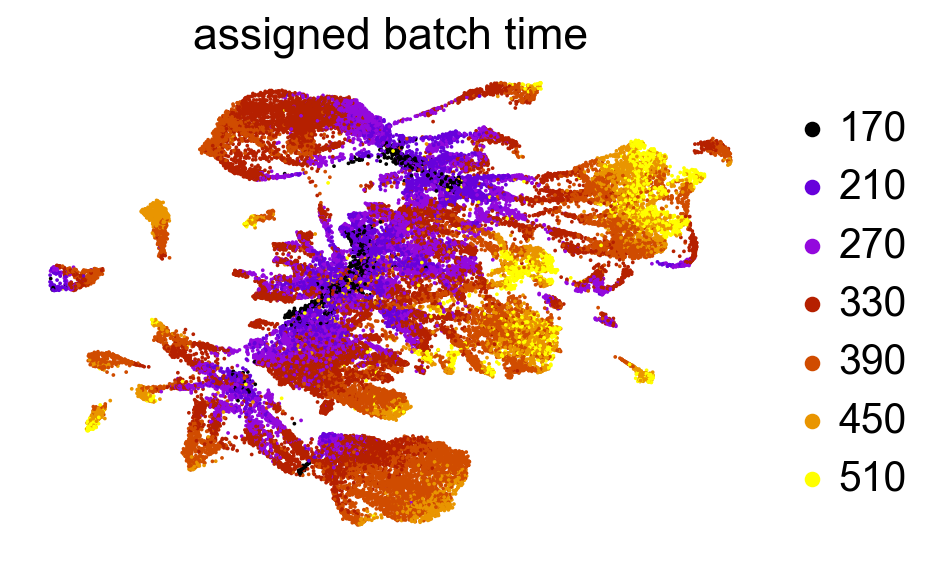

In [21]:
fig_kwargs = {}
if save_figure: fig_kwargs['save'] =  "full_umap_time.pdf"

scv.pl.scatter(adata, basis='umap', color=TIME_KEY, legend_loc='right', **fig_kwargs)

## Annotate and visualilze the two subsets

We work with two subsets in the paper: 

- cells with precise lineage information (`mask_1` below). 
- cells from the ABpxp lineage (`mask_2` below). 

In [22]:
# define a mask for precise lineage information
mask_1 = (
    adata.obs["lineage"].to_numpy()
    == adata.obs["random_precise_lineage"].to_numpy()
)

# define another mask for the ABpxp lineage
mask_2 = np.array(["ABpxp" in lin for lin in adata.obs['lineage']])

Do these two subsets overlap at all?

In [23]:
print(f"There are {np.sum(np.logical_and(mask_1, mask_2))} shared cells. ")

There are 0 shared cells. 


Let's create a convenient .obs annotation to acess these two subsets

In [24]:
subset = pd.Series(index=adata.obs.index)
subset[mask_1] = "precise"
subset[mask_2] = "ABpxp"
adata.obs["subset"] = subset.astype("category")

Visualize the subests on the UMAP. 

saving figure to file /Users/marius/Projects/moslin_reproducibility/figures/packer_c_elegans/full_umap_subset.pdf


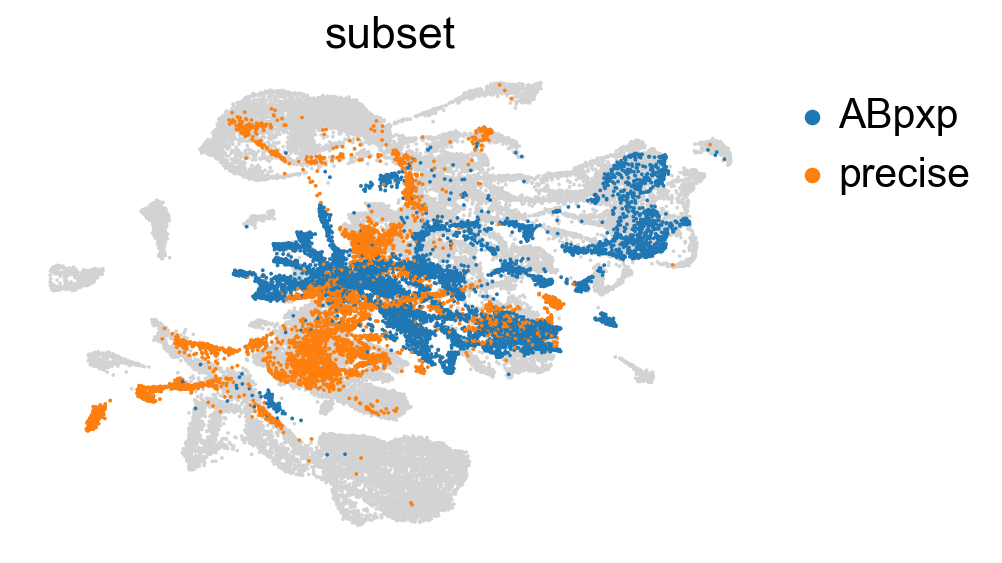

In [25]:
fig_kwargs = {}
if save_figure: fig_kwargs['save'] =  "full_umap_subset.pdf"

scv.pl.scatter(adata, c="subset", **fig_kwargs)